# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook's objective is to meet the requirements in the [rubric](https://review.udacity.com/#!/rubrics/481/view).

## Load Data

Load the traffic sign data, which came pre-packaged in Pickle files


In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
import pickle
import os
import math
import cv2
from scipy import ndimage

C:\Users\erede\Miniconda3\envs\carnd-term1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

35


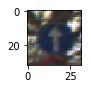

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

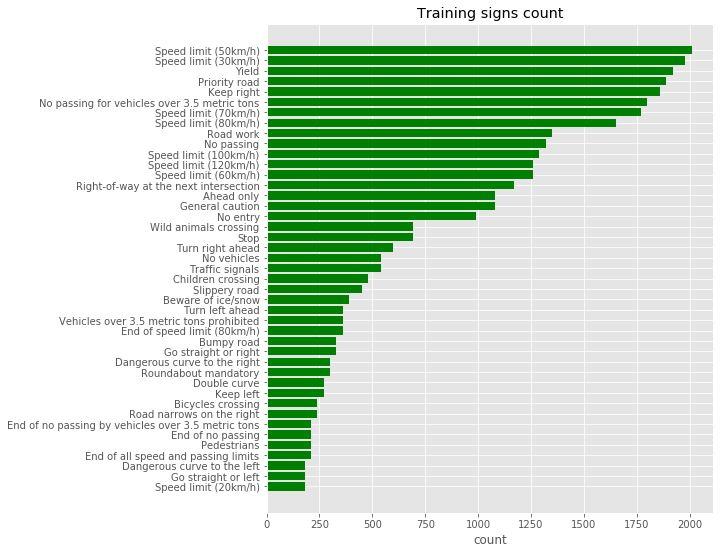

In [4]:
class_file_df = pd.read_csv("./signnames.csv", delimiter=',')

# How many unique classes/labels there are in the dataset.
n_classes = class_file_df.shape[0]

# Lets see how many of each type I have in my training data
plt.style.use('ggplot')
# get the counts of signs in the training dataset
unique, counts = np.unique(y_train, return_counts=True)
# since the signs are sorted 1-42 we can just add the count to the dataframe
class_file_df['train_count'] = pd.Series(counts,index=class_file_df.index)
# And sort the dataframe by the counts of the signs to make the plot look nice
class_file_df = class_file_df.sort_values(by=['train_count'])

# setup the plot and show it
fig = plt.figure(figsize=(8,9))
ax = fig.add_subplot(111)
signs = class_file_df['SignName']
y_pos = np.arange(len(signs))
count = class_file_df['train_count']

ax.barh(y_pos, count, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(signs)
ax.set_xlabel('count')
ax.set_title('Training signs count')
plt.show()

## Preprocess Data

Shuffle the training data.


In [5]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

Some helper functions to pre-process the data

In [6]:
def images_to_gray(images):
    output = []
    for image in images:
        output.append(image_to_gray(image))
    return output;

def image_to_gray(img):
    """Applies the YUV transform"""
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image

def normalize(image):
    """Normalizes images"""
    channels = cv2.split(image)
    channel_len = len(channels)
    num_image_elements = 32*32*channel_len
    chan = []
    image_chan_mean, image_chan_stddev = cv2.meanStdDev(image)
    for i in range(channel_len):
        chan.append(abs((channels[i]- image_chan_mean[i])/max(image_chan_stddev[i], 1./math.sqrt(num_image_elements))))
    return cv2.merge(chan)

def normalize(image):
    """Normalizes images"""
    channels = cv2.split(image)
    channel_len = len(channels)
    num_image_elements = 32*32*channel_len
    chan = []
    image_chan_mean, image_chan_stddev = cv2.meanStdDev(image)
    for i in range(channel_len):
        chan.append((channels[i]- image_chan_mean[i])/max(image_chan_stddev[i], 1./math.sqrt(num_image_elements)))
    return cv2.merge(chan)

def normalize_batch(images):
    output = []
    for image in images:
        output.append(normalize(image))
    return output

def random_image_distortion(image):
    if random.randint(0,10) > 5:
        distorted_image = rotate_image_random_amount(image)
    if random.randint(0,10) > 5:
        distorted_image = flip(image)
    else:
        return image
    distorted_image = np.reshape(distorted_image, [32,32,channels])
    return distorted_image

def rotate_image_random_amount(image):
    #https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point#9042907
    angle = random.randint(-90,90)
    #rotation angle in degree
    return ndimage.rotate(image, angle)

def flip(image):
    horizontal_img = cv2.flip( image, 0 )
    return horizontal_img

def increase_brightness(img, value=50):
    #https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [7]:
def preprocess_img(image, choice="gray_normal"):
    """
    Returns the preprocessed image based on the choice variable
    """
    return {
        'adaptive_th': cv2.adaptiveThreshold(image_to_gray(image),255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,3,3),
        'grayscale': image_to_gray(image),
        'gray_normal': normalize(image_to_gray(image)),
        'normal': normalize(image),
        'gray_bright': image_to_gray(increase_brightness(image, 120)),
    }[choice]

def preprocess_imgs(images, choice="gray_normal"):
    """
    Preprocesses a list of images
    """
    output = []
    if choice == "normal":
        channels = 3
    else:
        channels = 1
    for image in images:
        output.append(preprocess_img(image, choice))
    output = [np.reshape(me, [32,32,channels]) for me in output]
    return output

Pre-process the data to be set to grayscale and normalized

In [8]:
channels = 1
X_train = preprocess_imgs(X_train, 'gray_normal')
X_validation = preprocess_imgs(X_validation ,'gray_normal')
X_test = preprocess_imgs(X_test, 'gray_normal')


## Setup TensorFlow


In [9]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

## The Model:
Taking a hint from the [Stanford CS231n homepage](http://cs231n.stanford.edu/) I used the following architecture
### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [10]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, 0.75)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [11]:
from tensorflow.contrib.layers import flatten

def LeNetish(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32xchannels. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Layer 2: Convolutional. Output = 24x24x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 24x24x16. Output = 12x12x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 8x8x16.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 16), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(16))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # SOLUTION: Activation.
    conv3 = tf.nn.relu(conv3)

    # SOLUTION: Pooling. Input = 8x8x16. Output = 4x4x16.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Flatten. Input = 4x4x16. Output = 256.
    fc0   = flatten(conv3)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 256. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, 0.5)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [12]:
from tensorflow.contrib.layers import flatten

def LeNetish2(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    with tf.name_scope("conv1"):
        # Layer 1: Convolutional. Input = 32x32xchannels. Output = 30x30x6.
        conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, channels, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # Activation.
        conv1 = tf.nn.relu(conv1)
        
        tf.summary.histogram("weights", conv1_W)
        tf.summary.histogram("biases", conv1_b)
        tf.summary.histogram("activations", conv1)
    
    with tf.name_scope("conv2"):
        # Layer 2: Convolutional. Output = 28x28x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 6, 16), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        # Activation.
        conv2 = tf.nn.relu(conv2)
        
        tf.summary.histogram("weights", conv2_W)
        tf.summary.histogram("biases", conv2_b)
        tf.summary.histogram("activations", conv2)

        # Pooling. Input = 28x28x16. Output = 14x14x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    with tf.name_scope("conv3"):
        # Layer 3: Convolutional. Output = 12x12x32.
        conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
        conv3_b = tf.Variable(tf.zeros(32))
        conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b

        # Activation.
        conv3 = tf.nn.relu(conv3)
        
        tf.summary.histogram("weights", conv3_W)
        tf.summary.histogram("biases", conv3_b)
        tf.summary.histogram("activations", conv3)
        
    with tf.name_scope("conv4"):
        # Layer 4: Convolutional. Output = 10x10x64.
        conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
        conv4_b = tf.Variable(tf.zeros(64))
        conv4   = tf.nn.conv2d(conv3, conv4_W, strides=[1, 1, 1, 1], padding='VALID') + conv4_b

        # Activation.
        conv4 = tf.nn.relu(conv4)
        
        tf.summary.histogram("weights", conv4_W)
        tf.summary.histogram("biases", conv4_b)
        tf.summary.histogram("activations", conv4)

        # Pooling. Input = 10x10x64. Output = 5x5x64.
        conv4 = tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Flatten. Input = 4x4x16. Output = 1600.
    fc0   = flatten(conv4)
   
    with tf.name_scope("fc1"):
        # Layer : Fully Connected. Input = 1600. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b

        # Activation.
        fc1    = tf.nn.relu(fc1)
        
        tf.summary.histogram("weights", fc1_W)
        tf.summary.histogram("biases", fc1_b)
        tf.summary.histogram("activations", fc1)

    with tf.name_scope("fc2"):
        # Layer : Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b

        # Activation.
        fc2    = tf.nn.relu(fc2)
        fc2    = tf.nn.dropout(fc2, 0.5)
        
        tf.summary.histogram("weights", fc2_W)
        tf.summary.histogram("biases", fc2_b)
        tf.summary.histogram("activations", fc2)

    with tf.name_scope("logits"):
        # Layer : Fully Connected. Input = 84. Output = 10.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(43))
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        tf.summary.histogram("weights", fc3_W)
        tf.summary.histogram("biases", fc3_b)
        tf.summary.histogram("activations", logits)
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [14]:
rate = 0.001

logits = LeNetish2(x)
with tf.name_scope("cross-entropy"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits, name="cross-entropy")
    loss_operation = tf.reduce_mean(cross_entropy)
    tf.summary.scalar("cross-entropy", loss_operation)
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [15]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy_operation)
summ = tf.summary.merge_all()
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        [accuracy,s] = sess.run([accuracy_operation,summ], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        writer.add_summary(s, i)
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [16]:
LOGDIR = "./tensorboard_data/"
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR + "with image distortions")
    writer.add_graph(sess.graph)
    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x = [random_image_distortion(x) for x in batch_x]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.634

EPOCH 2 ...
Validation Accuracy = 0.771

EPOCH 3 ...
Validation Accuracy = 0.836

EPOCH 4 ...
Validation Accuracy = 0.869

EPOCH 5 ...
Validation Accuracy = 0.887

EPOCH 6 ...
Validation Accuracy = 0.905

EPOCH 7 ...
Validation Accuracy = 0.908

EPOCH 8 ...
Validation Accuracy = 0.915

EPOCH 9 ...
Validation Accuracy = 0.918

EPOCH 10 ...
Validation Accuracy = 0.920

Model saved


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [17]:
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('.'))

#     test_accuracy = evaluate(X_test, y_test)
#     print("Test Accuracy = {:.3f}".format(test_accuracy))